In [1]:
import os, sys
import json

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve

import torch
import torch.nn as nn
import torch.optim as optim

import keras
from keras import Sequential
from keras.layers import Activation, BatchNormalization, MaxPooling2D
from keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Reshape, InputLayer, Dropout
from keras.optimizers import SGD
from keras.utils import to_categorical
print(f'keras version: {keras.__version__}')

from tensorflow.keras.metrics import AUC as keras_auc
auc_metric = keras_auc()

Using TensorFlow backend.


keras version: 2.3.1


2022-04-14 16:13:08.546812: I tensorflow/core/platform/cpu_feature_guard.cc:145] This TensorFlow binary is optimized with Intel(R) MKL-DNN to use the following CPU instructions in performance critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in non-MKL-DNN operations, rebuild TensorFlow with the appropriate compiler flags.
2022-04-14 16:13:08.548257: I tensorflow/core/common_runtime/process_util.cc:115] Creating new thread pool with default inter op setting: 12. Tune using inter_op_parallelism_threads for best performance.


## Load data

In [2]:
global_params = json.load(open('../global_data_params.json', 'r'))
region_length = global_params['region_length']
bins_count = global_params['bins_count']
bps_per_bin = region_length // bins_count

In [3]:
FEATURE_DATA_PATH = '../feature_data'

In [4]:
positive_files = sorted(os.listdir(os.path.join(FEATURE_DATA_PATH, 'positive')))
negative_files = sorted(os.listdir(os.path.join(FEATURE_DATA_PATH, 'negative')))
assert positive_files == negative_files
histones_count = len(positive_files)

positive_size, negative_size = (
    # 192, 71817)
    pd.read_csv(os.path.join(FEATURE_DATA_PATH, 'positive', positive_files[0])).shape[0],
    pd.read_csv(os.path.join(FEATURE_DATA_PATH, 'negative', positive_files[0])).shape[0])
dataset_size = positive_size + negative_size
print('postive size:', positive_size)
print('negative size:', negative_size)
print('dataset size:', dataset_size)

postive size: 1961
negative size: 1144982
dataset size: 1146943


In [5]:
X_pos = np.zeros((positive_size, histones_count, bins_count))    # region, histone, bin
X_neg_all = np.zeros((negative_size, histones_count, bins_count))    # region, histone, bin

In [6]:
for i, file in enumerate(positive_files):
    print(f'positive: {file}')
    data = pd.read_csv(os.path.join(FEATURE_DATA_PATH, 'positive', file), sep='\t')
    X_pos[: , i, :] = data.loc[:, '0': str(bins_count - 1)]

for i, file in enumerate(negative_files):
    print(f'negative: {file}')
    data = pd.read_csv(os.path.join(FEATURE_DATA_PATH, 'negative', file), sep='\t')
    X_neg_all[: , i, :] = data.loc[:, '0': str(bins_count - 1)]

positive: mm9_Histone_H2A.X.sorted.pkbns
positive: mm9_Histone_H2A.XS139ph.sorted.pkbns
positive: mm9_Histone_H2A.Z.sorted.pkbns
positive: mm9_Histone_H2AK119Ub.sorted.pkbns
positive: mm9_Histone_H2Bub.sorted.pkbns
positive: mm9_Histone_H3.3.sorted.pkbns
positive: mm9_Histone_H3.sorted.pkbns
positive: mm9_Histone_H3K18ac.sorted.pkbns
positive: mm9_Histone_H3K27ac.sorted.pkbns
positive: mm9_Histone_H3K27me3.sorted.pkbns
positive: mm9_Histone_H3K36me2.sorted.pkbns
positive: mm9_Histone_H3K36me3.sorted.pkbns
positive: mm9_Histone_H3K4me1.sorted.pkbns
positive: mm9_Histone_H3K4me2.sorted.pkbns
positive: mm9_Histone_H3K4me3.sorted.pkbns
positive: mm9_Histone_H3K79me2.sorted.pkbns
positive: mm9_Histone_H3K79me3.sorted.pkbns
positive: mm9_Histone_H3K9K14ac.sorted.pkbns
positive: mm9_Histone_H3K9ac.sorted.pkbns
positive: mm9_Histone_H3K9acS10ph.sorted.pkbns
positive: mm9_Histone_H3K9me2.sorted.pkbns
positive: mm9_Histone_H3K9me3.sorted.pkbns
positive: mm9_Histone_H3R17me2.sorted.pkbns
positive

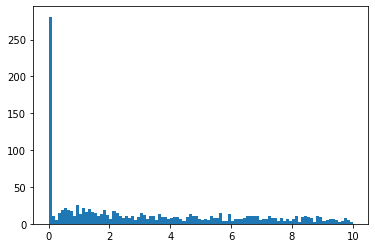

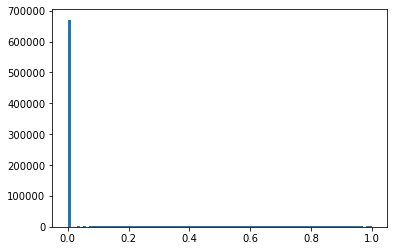

In [7]:

plt.hist(X_pos.mean(axis=(1, 2)), range=(0,10), bins=100)
plt.show()
plt.hist(X_neg_all.mean(axis=(1, 2)), range=(0,1), bins=100)
plt.show()

In [8]:
X_neg = X_neg_all[X_neg_all.mean(axis=(1, 2)) >= 0.2, :]
X_neg.shape

(454675, 33, 100)

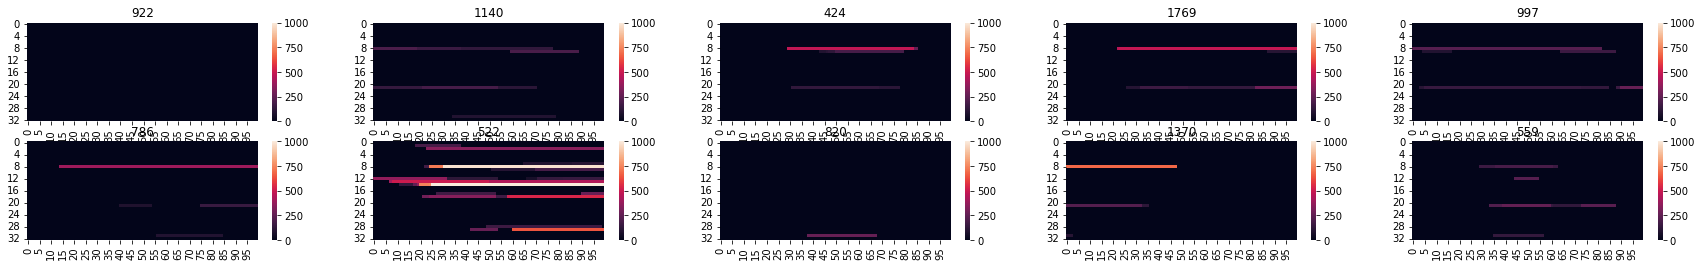

In [9]:
feature_on_image_size = (2, 5)
plt.figure(figsize=(feature_on_image_size[1] * 6, feature_on_image_size[0] * 2))
for ind, feature_num in enumerate(np.random.choice(X_pos.shape[0], feature_on_image_size[0] * feature_on_image_size[1])):
    plt.subplot(*feature_on_image_size, ind + 1)
    plt.title(feature_num)
    sns.heatmap(X_pos[feature_num], vmin=0, vmax=1000)
plt.show()

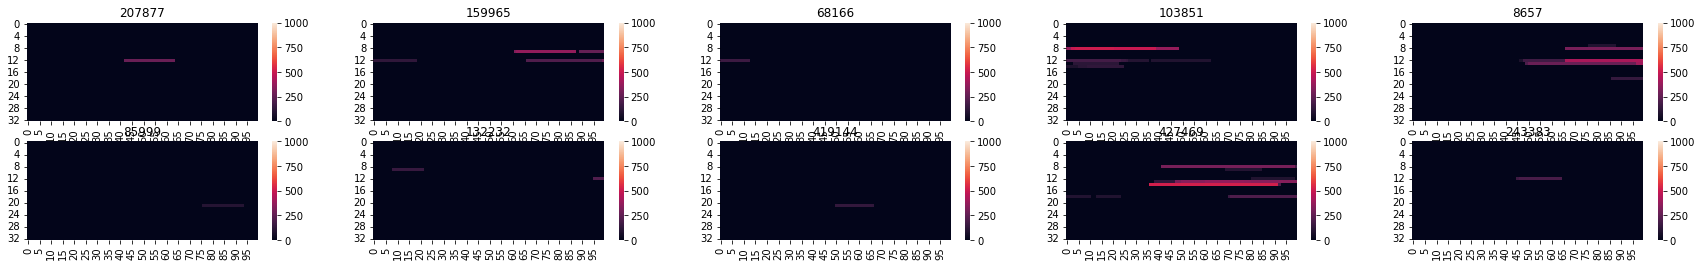

In [10]:
feature_on_image_size = (2, 5)
plt.figure(figsize=(feature_on_image_size[1] * 6, feature_on_image_size[0] * 2))
for ind, feature_num in enumerate(np.random.choice(X_neg.shape[0], feature_on_image_size[0] * feature_on_image_size[1])):
    plt.subplot(*feature_on_image_size, ind + 1)
    plt.title(feature_num)
    sns.heatmap(X_neg[feature_num], vmin=0, vmax=1000)
plt.show()

In [11]:
X = np.concatenate([X_pos, X_neg], dtype=np.double)
y = np.concatenate([
    np.ones((X_pos.shape[0])),
    np.zeros((X_neg.shape[0]))
])
assert X.shape[0] == y.shape[0]
print(X.shape, y.shape)

(456636, 33, 100) (456636,)


In [12]:
classes = 2

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
y_train_cat, y_test_cat = [to_categorical(y, classes) for y in [y_train, y_test]]
X_train_exp, X_test_exp = [np.expand_dims(x, axis=1) for x in [X_train, X_test]]

train_size, test_size = X_train.shape[0], X_test.shape[0]
print(f'train: {X_train.shape}, {y_train.shape}, {y_train_cat.shape}')
print(f'test: {X_test.shape}, {y_test.shape}, {y_test_cat.shape}')

train: (319645, 33, 100), (319645,), (319645, 2)
test: (136991, 33, 100), (136991,), (136991, 2)


## Learn model [pytorch]

In [15]:
'''model = nn.Sequential(
    nn.Conv2d(1, 16, (histones_count, 10), padding='valid'),
    nn.ReLU(),
    nn.Conv2d(16, 64, (1, 15), padding='valid'),
    nn.ReLU(),
    nn.Flatten(),
    
    nn.Linear(64 * 77, 50),
    nn.ReLU(),
    nn.Linear(50, 100),
    nn.ReLU(),
    nn.Linear(100, 200),
    nn.ReLU(),
    nn.Linear(200, 2),
    nn.Softmax(dim=1)
)
model = model.double()
loss_f = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)'''

"model = nn.Sequential(\n    nn.Conv2d(1, 16, (histones_count, 10), padding='valid'),\n    nn.ReLU(),\n    nn.Conv2d(16, 64, (1, 15), padding='valid'),\n    nn.ReLU(),\n    nn.Flatten(),\n    \n    nn.Linear(64 * 77, 50),\n    nn.ReLU(),\n    nn.Linear(50, 100),\n    nn.ReLU(),\n    nn.Linear(100, 200),\n    nn.ReLU(),\n    nn.Linear(200, 2),\n    nn.Softmax(dim=1)\n)\nmodel = model.double()\nloss_f = nn.CrossEntropyLoss()\noptimizer = optim.Adam(model.parameters(), lr=0.01)"

In [16]:
'''EPOCH_NUM = 10

train_losses=[]
valid_losses=[]

for epoch in range(EPOCH_NUM):
    model.train()
    optimizer.zero_grad()
    y_pred = model(torch.DoubleTensor(X_train))
    # print(y_pred)
    train_loss = loss_f(y_pred, torch.LongTensor(y_train))
    train_loss.backward()
    optimizer.step()

    model.eval()
    train_score = roc_auc_score(y_train, model(torch.DoubleTensor(X_train)).detach().numpy()[:, 0])
    test_score = roc_auc_score(y_test, model(torch.DoubleTensor(X_test)).detach().numpy()[:, 0])
    print(f'Epoch:{epoch}; Train score: {train_score:.4f}, test score: {test_score:.4f}')
    
    train_score = roc_auc_score(y_train, model(torch.DoubleTensor(X_train)).detach().numpy()[:, 1])
    test_score = roc_auc_score(y_test, model(torch.DoubleTensor(X_test)).detach().numpy()[:, 1])
    print(f'Epoch:{epoch}; Train score: {train_score:.4f}, test score: {test_score:.4f}')
    print(f'Loss: {train_loss}')
    print()
'''

"EPOCH_NUM = 10\n\ntrain_losses=[]\nvalid_losses=[]\n\nfor epoch in range(EPOCH_NUM):\n    model.train()\n    optimizer.zero_grad()\n    y_pred = model(torch.DoubleTensor(X_train))\n    # print(y_pred)\n    train_loss = loss_f(y_pred, torch.LongTensor(y_train))\n    train_loss.backward()\n    optimizer.step()\n\n    model.eval()\n    train_score = roc_auc_score(y_train, model(torch.DoubleTensor(X_train)).detach().numpy()[:, 0])\n    test_score = roc_auc_score(y_test, model(torch.DoubleTensor(X_test)).detach().numpy()[:, 0])\n    print(f'Epoch:{epoch}; Train score: {train_score:.4f}, test score: {test_score:.4f}')\n    \n    train_score = roc_auc_score(y_train, model(torch.DoubleTensor(X_train)).detach().numpy()[:, 1])\n    test_score = roc_auc_score(y_test, model(torch.DoubleTensor(X_test)).detach().numpy()[:, 1])\n    print(f'Epoch:{epoch}; Train score: {train_score:.4f}, test score: {test_score:.4f}')\n    print(f'Loss: {train_loss}')\n    print()\n"

## Learn mode keras [keras]

In [17]:
results = []

In [18]:
model = Sequential()
model.add(InputLayer((histones_count, bins_count)))
model.add(Reshape((histones_count, bins_count, 1)))
model.add(Conv2D(16, (histones_count, 10), padding='valid'))
model.add(Activation("relu"))
model.add(Conv2D(32, (1, 15), padding='valid'))
model.add(Activation("relu"))

model.add(Flatten())
model.add(Dense(50))
model.add(Activation("relu"))
model.add(Dense(100))
model.add(Activation("relu"))
model.add(Dense(200))
model.add(Activation("relu"))
model.add(Dense(2))
model.add(Activation("softmax"))

model.compile('adam', 'categorical_crossentropy', metrics=['acc', auc_metric])

model.fit(X_train, y_train_cat, batch_size=64, epochs=10)

y_test_probs = model.predict(X_test)[:, 1]
auc_roc = roc_auc_score(y_test, y_test_probs)

print(f'roc_auc: {auc_roc}')
results.append((auc_roc, model))

Epoch 1/10
319645/319645 [==============================] - 241s 755us/step - loss: 0.0375 - acc: 0.9954 - auc: 0.9964
Epoch 2/10
319645/319645 [==============================] - 604s 2ms/step - loss: 0.0351 - acc: 0.9960 - auc: 0.9978
Epoch 3/10
319645/319645 [==============================] - 325s 1ms/step - loss: 0.0269 - acc: 0.9961 - auc: 0.9980
Epoch 4/10
319645/319645 [==============================] - 285s 893us/step - loss: 0.0263 - acc: 0.9962 - auc: 0.9980
Epoch 5/10
319645/319645 [==============================] - 273s 855us/step - loss: 0.0260 - acc: 0.9962 - auc: 0.9980
Epoch 6/10
319645/319645 [==============================] - 284s 889us/step - loss: 0.0289 - acc: 0.9961 - auc: 0.9980
Epoch 7/10
319645/319645 [==============================] - 285s 891us/step - loss: 0.0297 - acc: 0.9962 - auc: 0.9980
Epoch 8/10
319645/319645 [==============================] - 211s 661us/step - loss: 0.0281 - acc: 0.9961 - auc: 0.9981
Epoch 9/10
319645/319645 [==========================

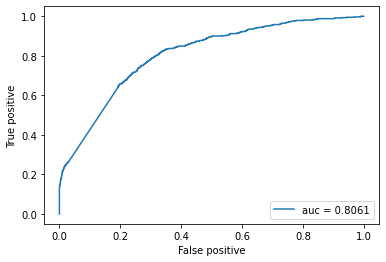

In [ ]:
fpr, tpr, threhold = roc_curve(y_test,  y_test_probs)
auc_roc = roc_auc_score(y_test, y_test_probs)
plt.plot(fpr, tpr, label=f"auc = {auc_roc:.4f}")
plt.legend(loc=4)
plt.xlabel('False positive')
plt.ylabel('True positive')
plt.show()

In [21]:
results

[(0.792804099590059, <keras.engine.sequential.Sequential at 0x7fdb20126b10>)]

In [20]:
with open('models-results2.txt', 'w+') as results_file:
    for score, model in results:
        print(score, file=results_file)
        model.summary(print_fn=lambda x: results_file.write(x + '\n'))
        print('=' * 70, file=results_file)
        print(file=results_file)

## Research feature importance

In [61]:
histones = list(map(lambda filename: filename[:filename.find('.sorted.pkbns')], positive_files))

In [34]:
feature_importances = []
for hist_ind, hist in enumerate(histones):
    X_test_no_hist = X_test.copy()
    X_test_no_hist[:, hist_ind, :] = np.zeros((test_size, bins_count))
    
    y_test_probs_no_hist = model.predict(X_test_no_hist)[:, 1]
    auc_roc_no_hist = roc_auc_score(y_test, y_test_probs_no_hist)
    auc_roc_diff = auc_roc - auc_roc_no_hist
    print(f'{hist:20} -- {auc_roc_no_hist:.4f} ({auc_roc_diff:.4f})')
    feature_importances.append((hist, auc_roc_no_hist, auc_roc_diff))


mm9_Histone_H2A      -- 0.7928 (0.0000)
mm9_Histone_H2A      -- 0.7920 (0.0008)
mm9_Histone_H2A      -- 0.7914 (0.0014)
mm9_Histone_H2AK119Ub -- 0.7928 (0.0000)
mm9_Histone_H2Bub    -- 0.7938 (-0.0010)
mm9_Histone_H3       -- 0.7927 (0.0001)
mm9_Histone_H3       -- 0.7927 (0.0001)
mm9_Histone_H3K18ac  -- 0.7920 (0.0008)
mm9_Histone_H3K27ac  -- 0.7223 (0.0705)
mm9_Histone_H3K27me3 -- 0.7260 (0.0668)
mm9_Histone_H3K36me2 -- 0.7928 (0.0000)
mm9_Histone_H3K36me3 -- 0.7900 (0.0028)
mm9_Histone_H3K4me1  -- 0.7285 (0.0643)
mm9_Histone_H3K4me2  -- 0.7881 (0.0047)
mm9_Histone_H3K4me3  -- 0.7860 (0.0068)
mm9_Histone_H3K79me2 -- 0.7930 (-0.0001)
mm9_Histone_H3K79me3 -- 0.7928 (-0.0000)
mm9_Histone_H3K9K14ac -- 0.7928 (0.0000)
mm9_Histone_H3K9ac   -- 0.7928 (0.0000)
mm9_Histone_H3K9acS10ph -- 0.7928 (0.0000)
mm9_Histone_H3K9me2  -- 0.7938 (-0.0010)
mm9_Histone_H3K9me3  -- 0.7346 (0.0582)
mm9_Histone_H3R17me2 -- 0.7928 (0.0000)
mm9_Histone_H3S10ph  -- 0.7928 (0.0000)
mm9_Histone_H3S28ph  -- 0.7926 

In [36]:
sorted_features = sorted(feature_importances, key=lambda x: abs(x[2]), reverse=True)
for best_result in sorted_features[:10]:
    print(f'{best_result[0]:20} -- {best_result[1]:.4f} ({best_result[2]:.4f})')

mm9_Histone_H3K27ac  -- 0.7223 (0.0705)
mm9_Histone_H3K27me3 -- 0.7260 (0.0668)
mm9_Histone_H3K4me1  -- 0.7285 (0.0643)
mm9_Histone_H3K9me3  -- 0.7346 (0.0582)
mm9_Histone_macroH2A1 -- 0.7834 (0.0094)
mm9_Histone_H3K4me3  -- 0.7860 (0.0068)
mm9_Histone_H3K4me2  -- 0.7881 (0.0047)
mm9_Histone_H3K36me3 -- 0.7900 (0.0028)
mm9_Histone_H2A      -- 0.7914 (0.0014)
mm9_Histone_H3K9me2  -- 0.7938 (-0.0010)


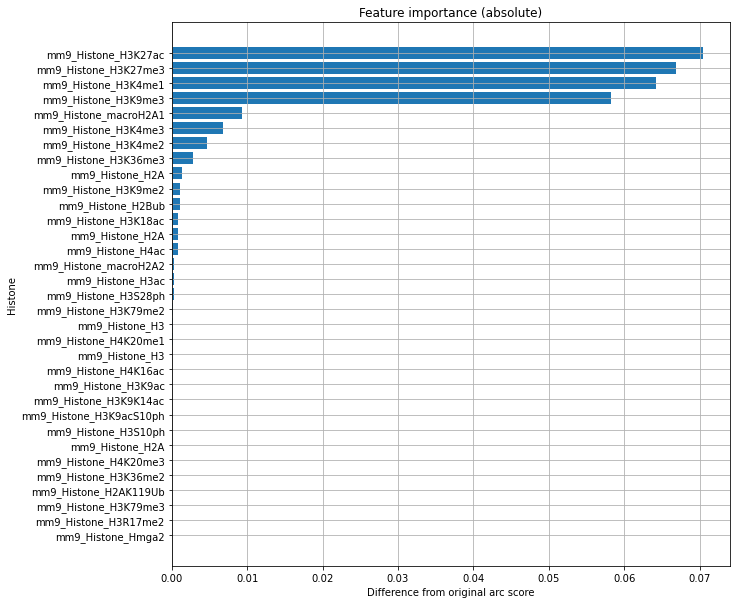

In [55]:
plt.figure(figsize=(10, 10))
plt.title('Feature importance (absolute)')
plt.barh(
    list(reversed(range(len(histones_count)))),
    list(map(lambda x: abs(x[2]), sorted_features))
)
plt.yticks(
    list(reversed(range(len(histones_count)))),
    labels=list(map(lambda x: x[0], sorted_features)))
plt.grid()
plt.ylabel('Histone')
plt.xlabel('Difference from original arc score')
plt.savefig('./img/feature_importance_bar.jpg', bbox_inches = 'tight')
plt.show()

In [57]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_1 (Reshape)          (None, 33, 100, 1)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 1, 91, 16)         5296      
_________________________________________________________________
activation_1 (Activation)    (None, 1, 91, 16)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 1, 77, 32)         7712      
_________________________________________________________________
activation_2 (Activation)    (None, 1, 77, 32)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 2464)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 50)               

In [58]:
filters = model.get_layer('conv2d_1').kernel.numpy()[:, :, 0, :]

filters: 16


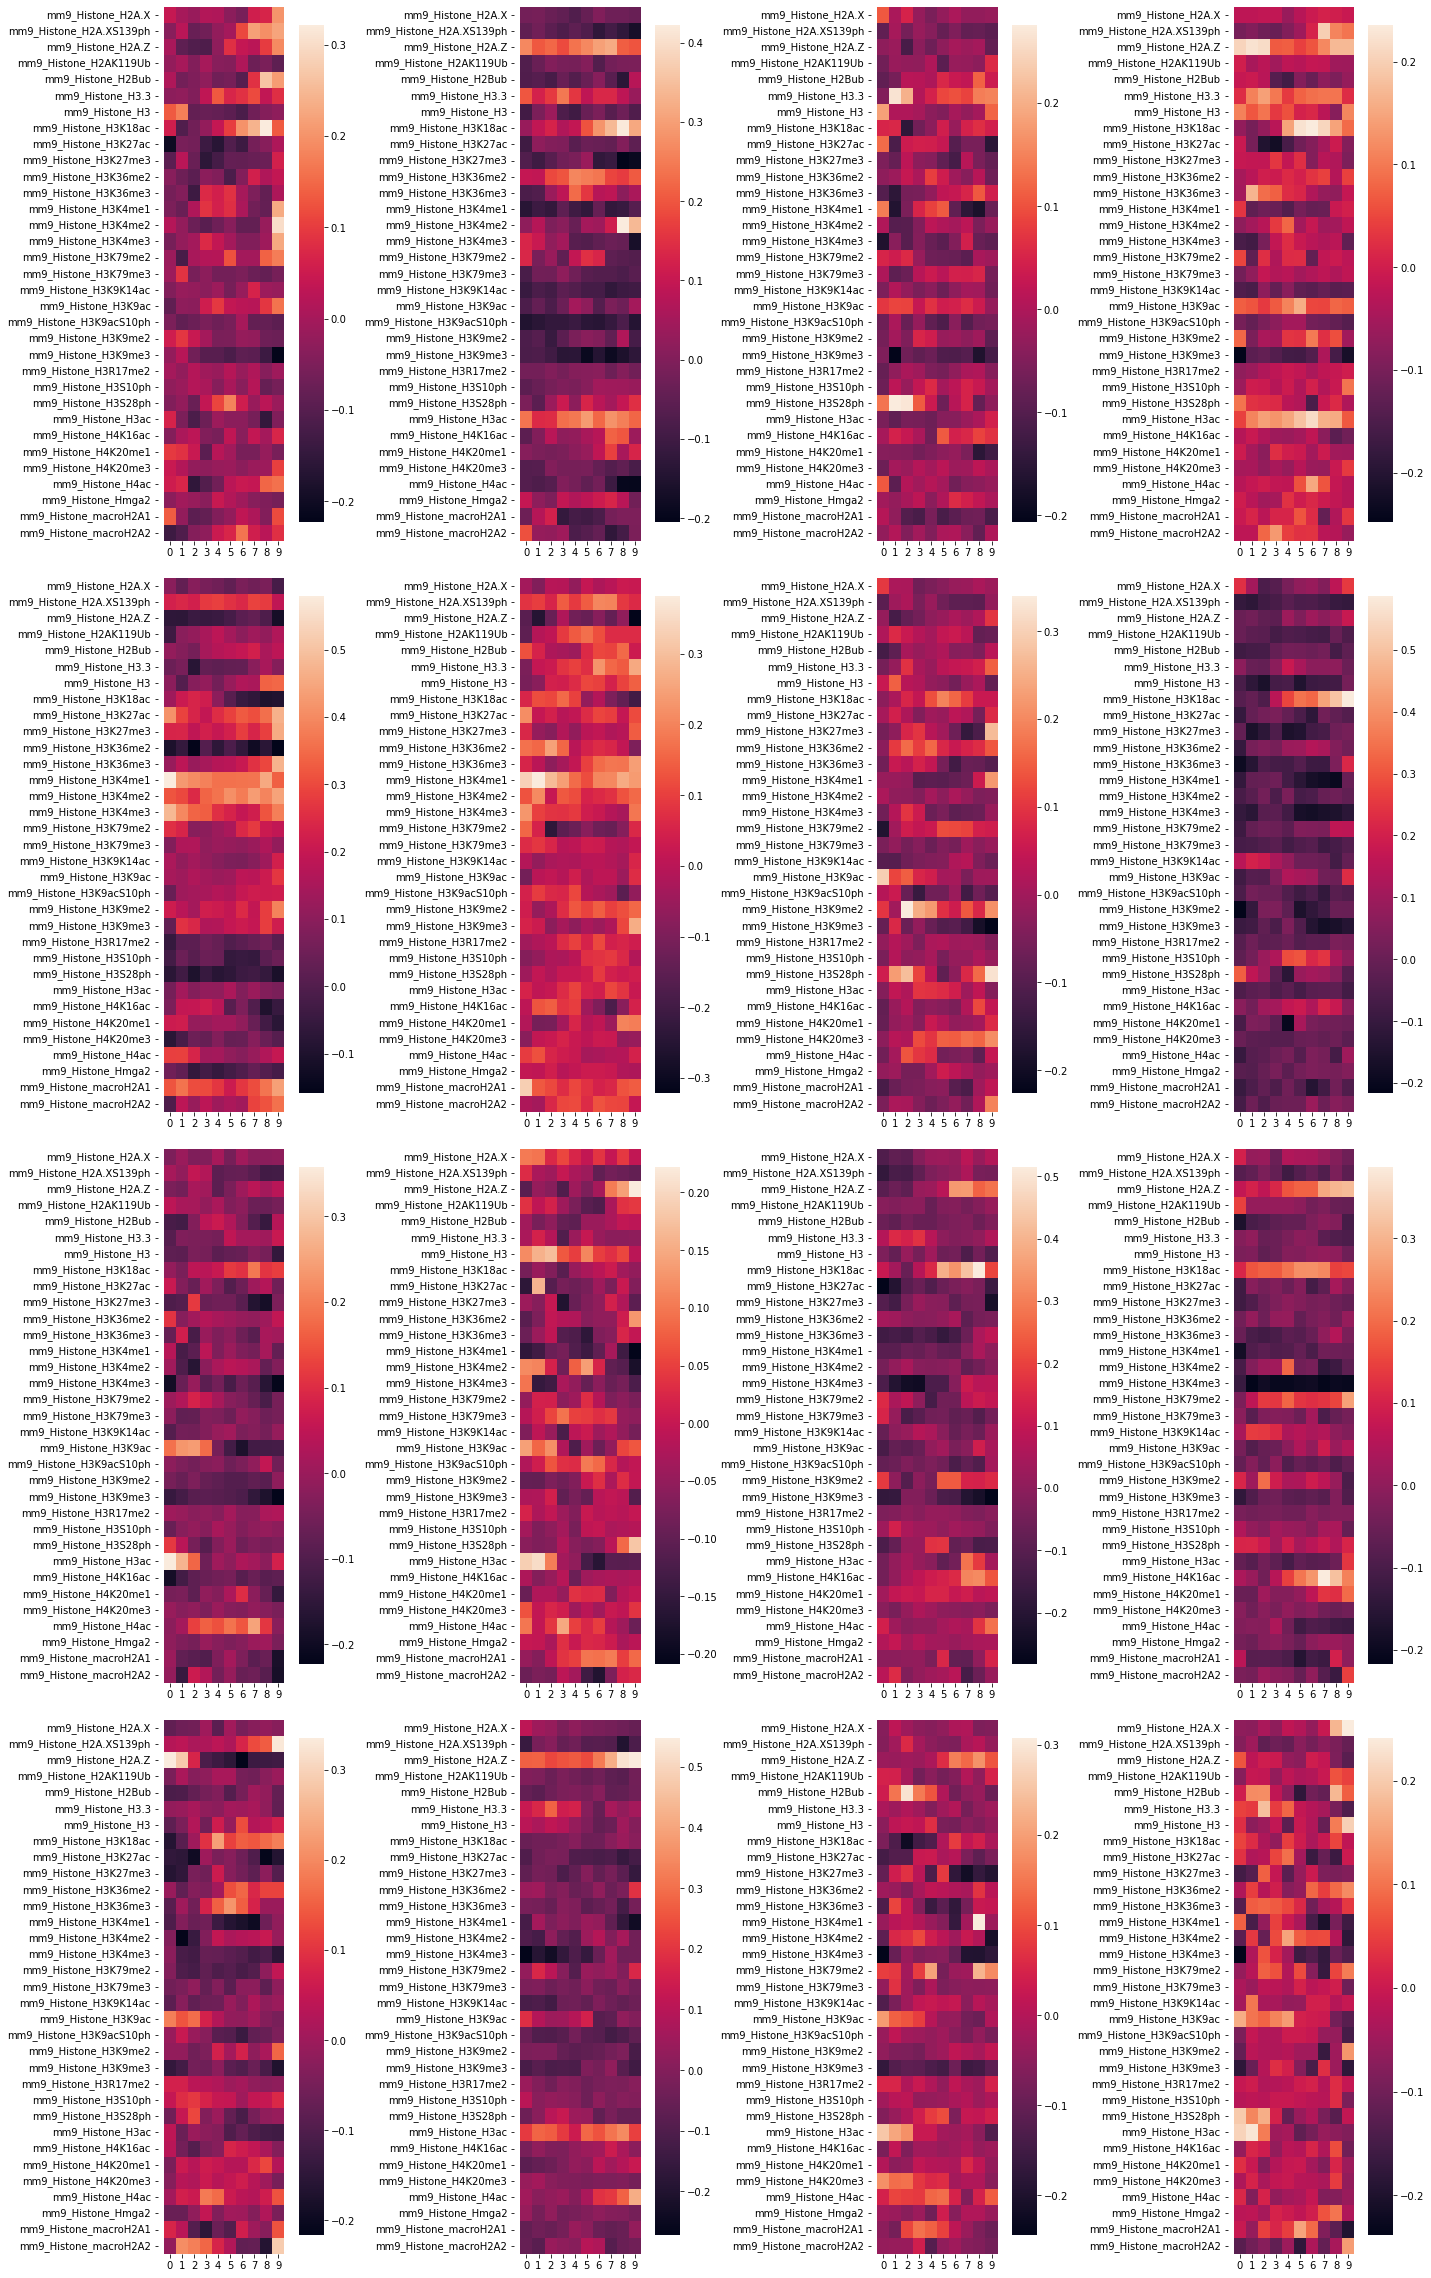

In [66]:
plt_fig_multiplier = 2
print(f'filters: {filters.shape[2]}' )

fig = plt.figure(figsize=(10 * plt_fig_multiplier, 16 * plt_fig_multiplier))

for filter_i in range(filters.shape[2]):
    plt.subplot(4, 4, filter_i + 1)
    sns.heatmap(filters[:, :, filter_i], cmap=None)
    plt.xlim(-0.5, 10.5)
    plt.yticks(np.arange(histones_count) + 0.5, histones, rotation=0)

plt.tight_layout(pad=2.0)
plt.savefig('img/filters.jpg', bbox_inches = 'tight')
plt.show()